In [1]:
# Load all depths and calculate mean metrics across all runs for each depth
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import numpy as np

results_dir = '../results_losses_circle'

# Define depths and loss types to analyze
depths = [1, 2, 3, 4, 5, 6, 7, 8]
# loss_types = ['trace_distance', 'hilbert_schmidt', 'inner_loss']
loss_types = ['trace_distance', 'inner_loss']
depth_loss_results = {}

for depth in depths:
    depth_loss_results[depth] = {}
    
    for loss_type in loss_types:
        # Filter TQFM pickle files for this depth and loss type
        pattern = f'tqfm_{loss_type}_depth{depth}_'
        tqfm_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and pattern in f]
        
        if not tqfm_files:
            print(f"No files found for depth {depth}, loss {loss_type}")
            continue
        
        # Load all models for this depth and loss type
        models_data = []
        for tqfm_file in sorted(tqfm_files):
            try:
                with open(os.path.join(results_dir, tqfm_file), 'rb') as f:
                    tqfm = pickle.load(f)
                    
                    # Skip if best_params is None
                    if tqfm.best_params is None:
                        print(f"  Skipping {tqfm_file}: best_params is None")
                        continue
                    
                    final_loss = tqfm.loss_history[-1] if len(tqfm.loss_history) > 0 else None
                    train_acc = tqfm.train_accuracy_history[-1] if tqfm.train_accuracy_history else None
                    
                    if final_loss is not None and train_acc is not None:
                        models_data.append({
                            'tqfm': tqfm,
                            'file': tqfm_file,
                            'loss': final_loss,
                            'train_acc': train_acc
                        })
            except Exception as e:
                print(f"  Error loading {tqfm_file}: {e}")
        
        if models_data:
            # Calculate mean metrics across all valid runs
            mean_loss = np.mean([m['loss'] for m in models_data])
            std_loss = np.std([m['loss'] for m in models_data])
            mean_train_acc = np.mean([m['train_acc'] for m in models_data])
            std_train_acc = np.std([m['train_acc'] for m in models_data])
            
            depth_loss_results[depth][loss_type] = {
                'mean_loss': mean_loss,
                'std_loss': std_loss,
                'mean_train_acc': mean_train_acc,
                'std_train_acc': std_train_acc,
                'n_runs': len(models_data),
                'models': models_data
            }
            
            print(f"Depth {depth}, {loss_type}: {len(models_data)} valid runs")
            print(f"  Mean Loss: {mean_loss:.6f} ± {std_loss:.6f}")
            print(f"  Mean Train Acc: {mean_train_acc:.4f} ± {std_train_acc:.4f}")

print(f"\nTotal depths analyzed: {len(depth_loss_results)}")
print(f"Loss types: {loss_types}")

Depth 1, trace_distance: 20 valid runs
  Mean Loss: 0.502276 ± 0.027426
  Mean Train Acc: 0.8975 ± 0.0151
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run15.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run16.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run2.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run6.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run9.pkl: best_params is None
Depth 1, inner_loss: 15 valid runs
  Mean Loss: 0.342972 ± 0.037620
  Mean Train Acc: 0.7673 ± 0.0881
Depth 2, trace_distance: 20 valid runs
  Mean Loss: 0.448634 ± 0.027180
  Mean Train Acc: 0.8980 ± 0.0129
Depth 2, inner_loss: 20 valid runs
  Mean Loss: 0.340468 ± 0.057671
  Mean Train Acc: 0.8055 ± 0.0747
Depth 3, trace_distance: 20 valid runs
  Mean Loss: 0.392577 ± 0.039975
  Mean Train Acc: 0.8935 ± 0.0135
Depth 

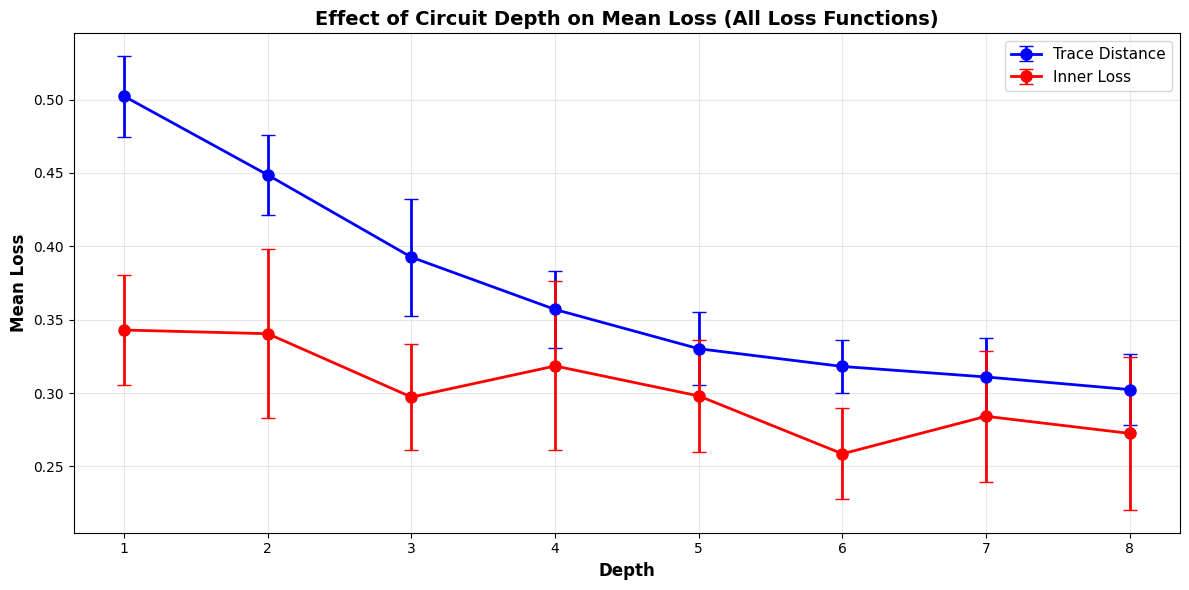

Mean Loss Summary:

TRACE_DISTANCE:
  Depth 1: 0.502276 ± 0.027426 (n=20)
  Depth 2: 0.448634 ± 0.027180 (n=20)
  Depth 3: 0.392577 ± 0.039975 (n=20)
  Depth 4: 0.356979 ± 0.026536 (n=20)
  Depth 5: 0.330224 ± 0.024923 (n=20)
  Depth 6: 0.318152 ± 0.018062 (n=20)
  Depth 7: 0.310991 ± 0.026889 (n=20)
  Depth 8: 0.302385 ± 0.024387 (n=20)

INNER_LOSS:
  Depth 1: 0.342972 ± 0.037620 (n=15)
  Depth 2: 0.340468 ± 0.057671 (n=20)
  Depth 3: 0.297245 ± 0.036172 (n=20)
  Depth 4: 0.318476 ± 0.057598 (n=20)
  Depth 5: 0.298052 ± 0.038371 (n=20)
  Depth 6: 0.258623 ± 0.031048 (n=20)
  Depth 7: 0.284180 ± 0.044757 (n=20)
  Depth 8: 0.272517 ± 0.052208 (n=20)


In [2]:
# Visualize Mean Loss vs Depth for all loss types
import matplotlib.pyplot as plt
import numpy as np

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

# colors = {'trace_distance': 'blue', 'hilbert_schmidt': 'green', 'inner_loss': 'red'}
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}

for loss_type in loss_types:
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        plt.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5, 
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Loss', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Loss (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.tight_layout()
plt.show()

print("Mean Loss Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_loss']:.6f} ± {result['std_loss']:.6f} (n={result['n_runs']})")

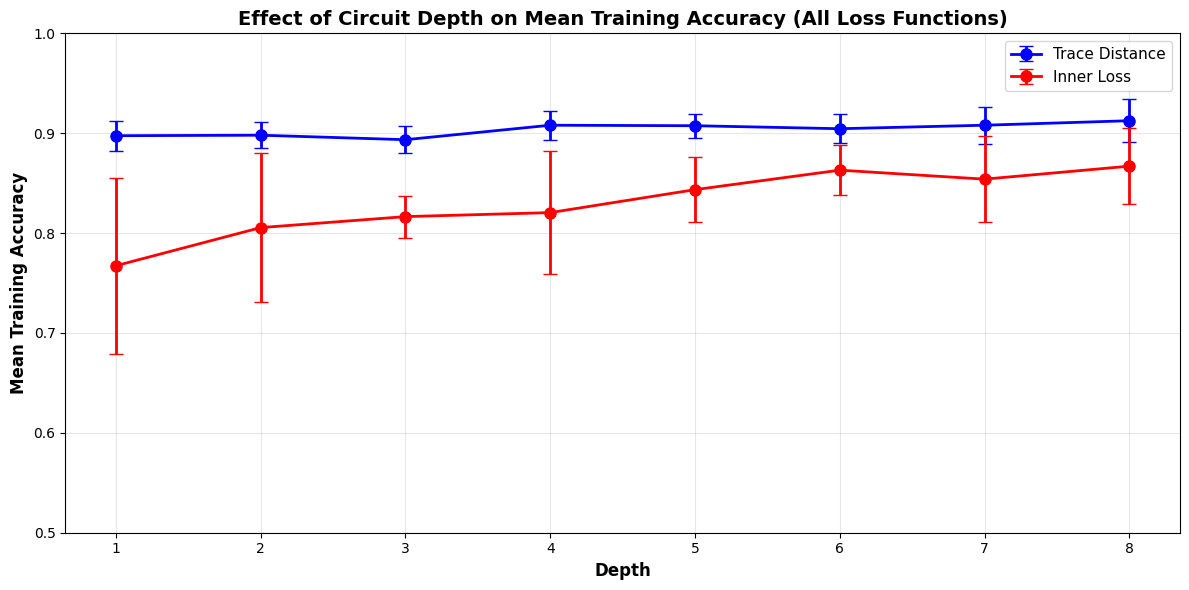


Mean Training Accuracy Summary:

TRACE_DISTANCE:
  Depth 1: 0.8975 ± 0.0151 (n=20)
  Depth 2: 0.8980 ± 0.0129 (n=20)
  Depth 3: 0.8935 ± 0.0135 (n=20)
  Depth 4: 0.9080 ± 0.0144 (n=20)
  Depth 5: 0.9075 ± 0.0122 (n=20)
  Depth 6: 0.9045 ± 0.0143 (n=20)
  Depth 7: 0.9080 ± 0.0183 (n=20)
  Depth 8: 0.9125 ± 0.0217 (n=20)

INNER_LOSS:
  Depth 1: 0.7673 ± 0.0881 (n=15)
  Depth 2: 0.8055 ± 0.0747 (n=20)
  Depth 3: 0.8165 ± 0.0210 (n=20)
  Depth 4: 0.8205 ± 0.0616 (n=20)
  Depth 5: 0.8435 ± 0.0328 (n=20)
  Depth 6: 0.8630 ± 0.0253 (n=20)
  Depth 7: 0.8540 ± 0.0429 (n=20)
  Depth 8: 0.8670 ± 0.0382 (n=20)


In [3]:
# Visualize Mean Training Accuracy vs Depth for all loss types
depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

# colors = {'trace_distance': 'blue', 'hilbert_schmidt': 'green', 'inner_loss': 'red'}
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}

for loss_type in loss_types:
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        plt.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Training Accuracy (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

print("\nMean Training Accuracy Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_train_acc']:.4f} ± {result['std_train_acc']:.4f} (n={result['n_runs']})")

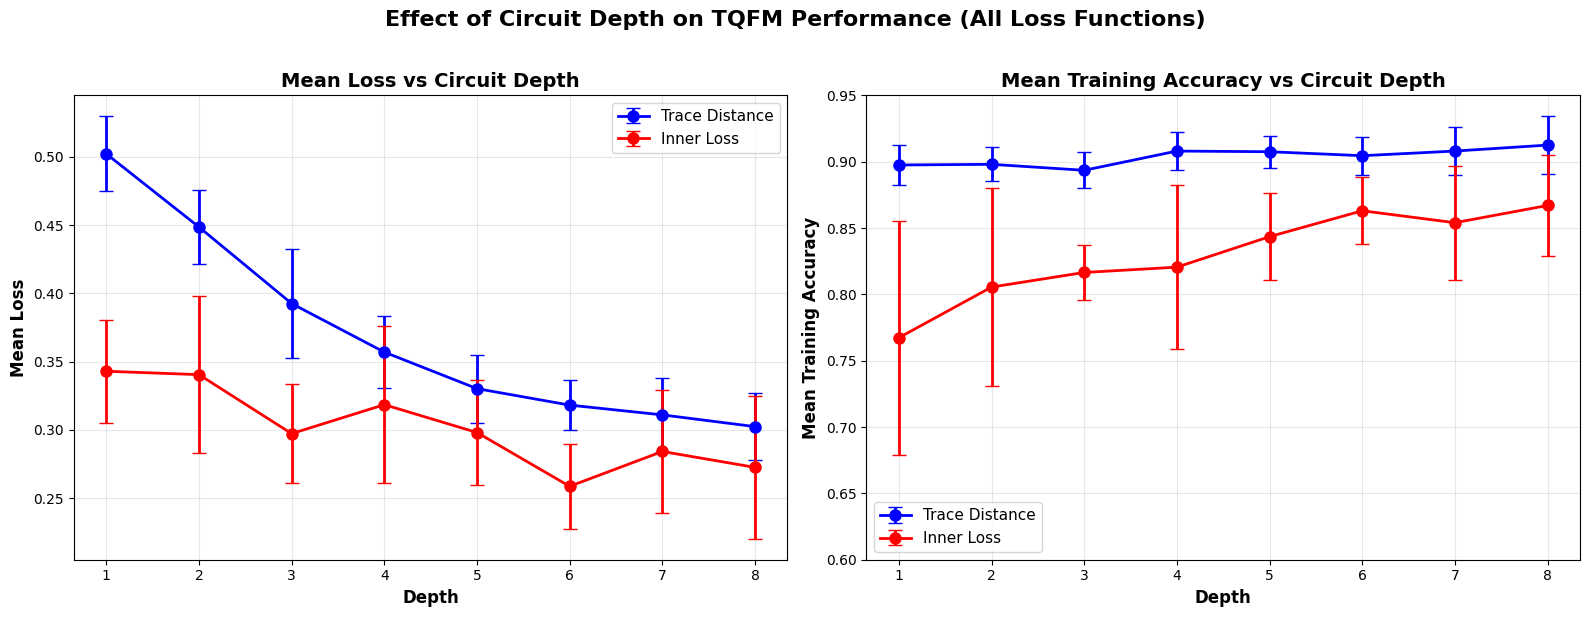

: 

In [ ]:
# Combined visualization: Mean Loss and Mean Accuracy for all loss types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])
# colors = {'trace_distance': 'blue', 'hilbert_schmidt': 'green', 'inner_loss': 'red'}
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}


# Left plot: Mean Loss vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        ax1.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

ax1.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Loss', fontsize=12, fontweight='bold')
ax1.set_title('Mean Loss vs Circuit Depth', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)

# Right plot: Mean Training Accuracy vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        ax2.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

ax2.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Mean Training Accuracy vs Circuit Depth', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)
ax2.set_ylim([0.6, 0.95])

plt.suptitle('Effect of Circuit Depth on TQFM Performance (All Loss Functions)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()